# Hotel Recommendations
- By using Content Based Recommender System to recommend hotels in the US
    - Content Based Recommender system recommends a item similar to what the user likes based on the user's past actions or feedbacks
    
- In this project, a content based recommender system will be built to recommend 10 hotels in the US

# Importing Modules & Functions

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import  WordCloud,STOPWORDS
import string
import random
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics.pairwise import linear_kernel  # Changing values from 0 to 1

In [82]:
bad_symbol_represent = re.compile('[/(){}\[\]\|@,;]')
def text_cleaning(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = bad_symbol_represent.sub(' ', text) # No punctuations
    text = ' '.join(w for w in text.split() if w not in STOPWORDS) # remove stopwors from text
    text_lem = [lemmatizer.lemmatize(w) for w in text]
    text_lem = "".join(text_lem)
    return text_lem


# Text Preprocessing
- Remove Punctuations, change to lowercase, remove stopwords and lemmatize the text

In [107]:
data = pd.read_csv(open("cleaned_hotel_dataset.csv",errors = 'replace',encoding = "UTF-8"))

In [108]:
# Combine all of those columns into one
data['description'] = data[['address', 'city','province','reviews.text','reviews.title']].apply(
    lambda x: ' '.join(x.fillna('').astype(str)),axis=1)



In [109]:
data_group = data.groupby('name')['description'].apply(lambda x: x.sum()).reset_index()
data_group = pd.DataFrame(data_group)
data_group

,name,description
0,1785 Inn,3582 White Mountain Hwy North Conway N Conway ...
1,1900 House,59 Kingstown Rd Narragansett Galilee The 1900 ...
2,40 Berkeley Hostel,40 Berkeley St Boston MA We booked this hostel...
3,A Bed & Breakfast In Cambridge,1657 Cambridge St Cambridge MA Breakfast was t...
4,Ambassadors Inn and Suites,716 21st St Virginia Beach VA Relaxing. Nice a...
...,...,...
402,Wingate By Wyndham Chantilly / Dulles Airport,3940 Centerview Dr Chantilly VA This was an ov...
403,Wingate By Wyndham Lagrange,103 Wingate Ter Lagrange GA The stay was aweso...
404,Wingate By Wyndham Pueblo,"4711 N Elizabeth Pueblo CO Great stay, differe..."
405,Wyndham Resort At Fairfield Mountains,747 Buffalo Creek Rd Lake Lure NC Great area w...


In [86]:
data_group['description'] = data_group['description'].apply(text_cleaning)

In [87]:
data_group

,name,description
0,1785 Inn,3582 white mountain hwy north conway 1785 inn ...
1,1900 House,59 kingstown rd narragansett 1900 house galile...
2,40 Berkeley Hostel,40 berkeley st boston 40 berkeley hostel ma bo...
3,A Bed & Breakfast In Cambridge,1657 cambridge st cambridge bed & breakfast ca...
4,Ambassadors Inn and Suites,716 21st st virginia beach ambassadors inn sui...
...,...,...
402,Wingate By Wyndham Chantilly / Dulles Airport,3940 centerview dr chantilly wingate wyndham c...
403,Wingate By Wyndham Lagrange,103 wingate ter lagrange wingate wyndham lagra...
404,Wingate By Wyndham Pueblo,4711 n elizabeth pueblo wingate wyndham pueblo...
405,Wyndham Resort At Fairfield Mountains,747 buffalo creek rd lake lure wyndham resort ...


### Converting  the description to vectors by using TfidfVectorizer

In [89]:

tfv = TfidfVectorizer(min_df = 3, max_features = None, strip_accents = 'unicode',analyzer = 'word',ngram_range = (1,4),stop_words = 'english')

In [90]:
data_tfv = tfv.fit_transform(data_group['description'])

### By using linear kernel, I compare the text vectors to each other and receive a relativity probabilities between those two.

In [91]:
lin = linear_kernel(data_tfv,data_tfv)

In [92]:
indices = pd.Series(data_group.index, index = data_group['name']).drop_duplicates()

### Making a pipeline of Content-Based Recommender System

In [93]:
def recommendation_content(title,lin=lin):
    idx = indices[title]
    recsys = list(enumerate(lin[idx]))
    recsys = sorted(recsys,key = lambda x:x[1],reverse =True)
    # Shows top 10 recommendations
    recsys = recsys[1:11]
    
    # Top 10 indices
    similarity_score = [i[0] for i in recsys]
    
    return data_group['name'].iloc[similarity_score]

# Testing the Content-Based Recommender System
- Trying to get 10 hotel recommendations with a given example

In [112]:
random_hotel = data.iloc[111]['name']

In [114]:
random_hotel

'Hawthorn Suites By Wyndham Livermore Wine Country'

### Top 10 Most Similar Hotels List

In [116]:
content_recommendations_top10=pd.DataFrame(recommendation_content(random_hotel).values,columns={'Hotel Names'}).reset_index().drop('index',axis = 1)
content_recommendations_top10

,Hotel Names
0,Hawthorn Suites Dayton North
1,Microtel Inn and Suites By Wyndham Burlington
2,Cherokee Lodge Bed and Breakfast
3,Microtel Inn Suites By Wyndham San Antonio By ...
4,Super 8 - Effingham
5,Gardena Terrace Inn
6,Holiday Inn Victorville
7,Norwood Inn and Suites
8,Wyndham Resort At Fairfield Mountains
9,Comfort Inn Livermore


## Evaluations On The Content-Based Recommender System

- By using wordclouds, to detect the similar words between 'Best Western Plus Waterville Grand Hotel' and it's similar hotels.

In [119]:
content_recommendations_top10

,Hotel Names
0,Hawthorn Suites Dayton North
1,Microtel Inn and Suites By Wyndham Burlington
2,Cherokee Lodge Bed and Breakfast
3,Microtel Inn Suites By Wyndham San Antonio By ...
4,Super 8 - Effingham
5,Gardena Terrace Inn
6,Holiday Inn Victorville
7,Norwood Inn and Suites
8,Wyndham Resort At Fairfield Mountains
9,Comfort Inn Livermore


In [121]:
content_recommendations_top10 = content_recommendations_top10['Hotel Names'].astype(str)

In [122]:
# Randomly choose 3 hotels in the top 10 recommendations
ran_num =random.sample(range(0,9), 3)

### WordClouds

In [123]:
# generating wordcloud respect to it's index
def generate_wordcloud(i):
    wordcloud = WordCloud(width = 1000, height = 1000,background_color = 'black',stopwords=set(STOPWORDS)).generate(" ".join(data_group[data_group['name'] == content_recommendations_top10[i] ]['description'].values))
    return wordcloud

Best Western Plus Waterville Grand Hotel


(-0.5, 999.5, 999.5, -0.5)

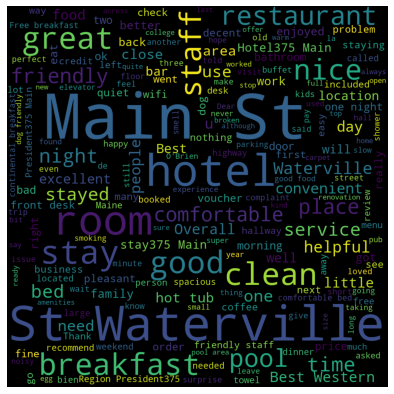

In [124]:
# wordcloud of 'Best Western Plus Waterville Grand Hotel'

plt.figure(figsize=(10,7))
wordcloud_bwpwgh = WordCloud(width=1000,height=1000, background_color='black',stopwords=set(STOPWORDS)).generate(" ".join(data_group[data_group['name'] == 'Best Western Plus Waterville Grand Hotel']['description'].values))
print('Best Western Plus Waterville Grand Hotel')
plt.imshow(wordcloud_bwpwgh)
plt.axis('off')

Microtel Inn Suites By Wyndham San Antonio By Seaworld


(-0.5, 999.5, 999.5, -0.5)

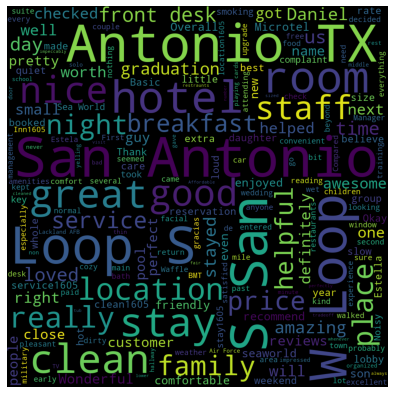

In [125]:
# Let's compare random 3 places with the selected hotel
wordcloud = generate_wordcloud(ran_num[0])
plt.figure(figsize = (10,7))
print(content_recommendations_top10[ran_num[0]])
plt.imshow(wordcloud)
plt.axis('off')
    

Norwood Inn and Suites


(-0.5, 999.5, 999.5, -0.5)

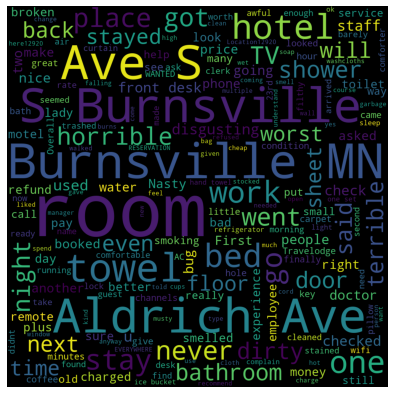

In [126]:
wordcloud = generate_wordcloud(ran_num[1])
plt.figure(figsize = (10,7))
print(content_recommendations_top10[ran_num[1]])
plt.imshow(wordcloud)
plt.axis('off')

Holiday Inn Victorville


(-0.5, 999.5, 999.5, -0.5)

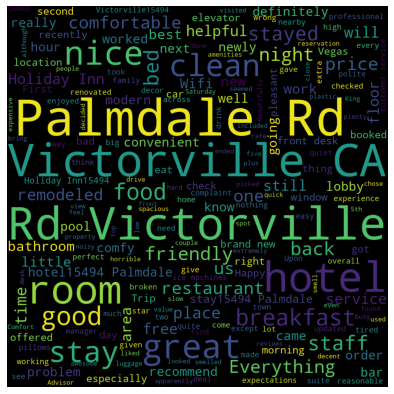

In [127]:
wordcloud = generate_wordcloud(ran_num[2])
plt.figure(figsize = (10,7))
print(content_recommendations_top10[ran_num[2]])
plt.imshow(wordcloud)
plt.axis('off')

- The location of the hotels(E.g: City, neighbourhoods) and the condition of the room were the main keys to find the best recommendations